# Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import sys
import gc
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelBinarizer
import PIL
from PIL import Image
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import keras
from keras.applications import InceptionV3
from keras import layers
from keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras import optimizers
from keras import models
from keras.models import Sequential, Model
from keras import preprocessing
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import plot_model

Using TensorFlow backend.


# Global variables

In [2]:
img_size = 299
batch_size = 32
epochs = 100
train_size = 0.7
val_size = 0.2
test_size = 0.1
seed = 4321
channels = 3
learning_rate = 0.00001

# Get classes and entries per classes

['Letter', 'Resume', 'Scientific', 'ADVE', 'Email', 'Report', 'News', 'Memo', 'Form', 'Note']
[568, 121, 262, 231, 600, 266, 189, 621, 432, 202]


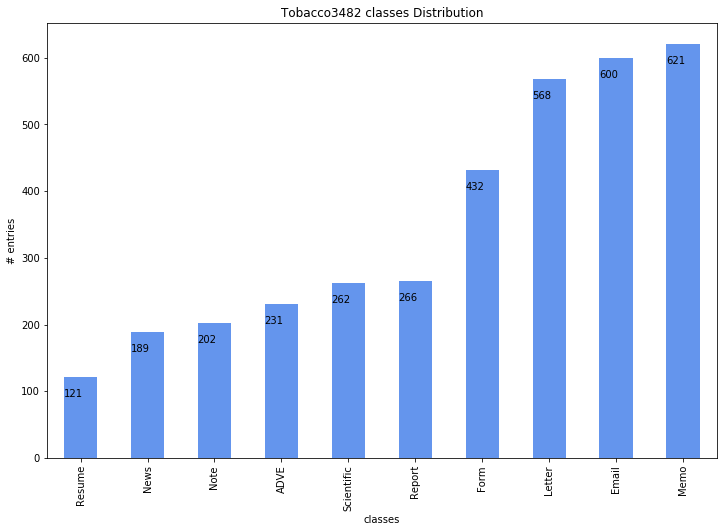

In [3]:
d = '../input/tobacco3482-jpg/Tobacco3482-jpg/'
PATH = '../'

classes = (os.listdir(d))

paths = [os.path.join(d, o) for o in os.listdir(d) 
                    if os.path.isdir(os.path.join(d,o))]

nbEntries = []

for i in range(len(classes)):
    nbEntries.append(len(os.listdir(paths[i])))

#################################################
    
print(classes)
print(nbEntries)

df = pd.DataFrame({'classes':classes, 'entries':nbEntries})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('Tobacco3482 classes Distribution')
ax.set_ylabel("# entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-30))

# Get all images

In [4]:
total_set = []
total_labels = []


for root, dirs, files in os.walk(d):
    for file in files:
        if file.endswith(".jpg"):
            path = os.path.join(root, file)
            total_set.append(path)
            total_labels.append(root.split(os.path.sep)[-1])
            

# Return image class based on list entry (path)         
def getClass(img):
    return img.split(os.path.sep)[-2]


print(total_set[0])
print('GetClass : ', getClass(total_set[0]))
print('Label : ', total_labels[0])

../input/tobacco3482-jpg/Tobacco3482-jpg/Letter/507360836+-0837.jpg
GetClass :  Letter
Label :  Letter


# Plot data 

../input/tobacco3482-jpg/Tobacco3482-jpg/ADVE/2070262428_2429.jpg


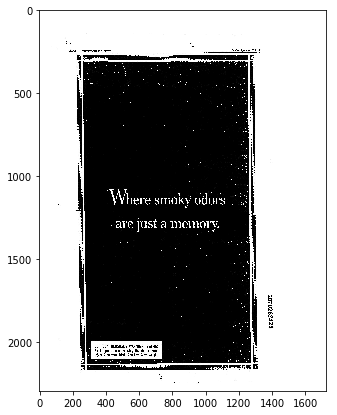

../input/tobacco3482-jpg/Tobacco3482-jpg/Form/2045829634_9635.jpg


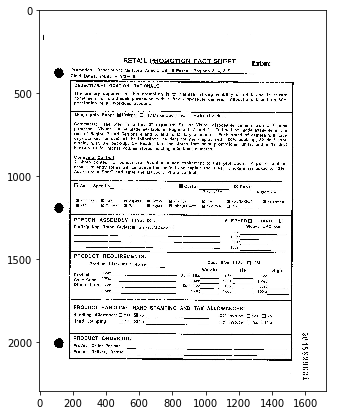

../input/tobacco3482-jpg/Tobacco3482-jpg/Letter/50030592.jpg


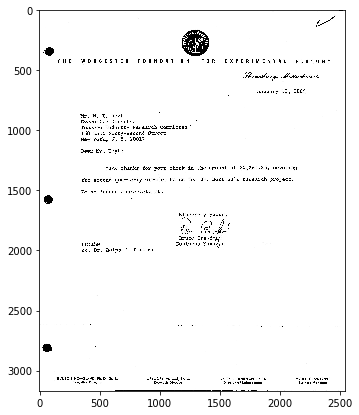

In [5]:
random.Random(seed).shuffle(total_set)

for ima in total_set[0:3] :
    print(ima)
    img = mpimg.imread(ima)
    plt.figure(figsize=(7,7))
    imgplot = plt.imshow(img, cmap="gray")
    plt.show()


# Sorting data in usable sets
![](https://cdn-images-1.medium.com/max/800/1*HpvpA9pBJXKxaPCl5tKnLg.jpeg)

In [6]:
# Get data and separate it in sets
total_len = len(total_set)
index = 0

train_set = []
train_label = []

val_set = []
val_label = []

test_set = []
test_label = []


for i in total_set[0: int(total_len*train_size)] :
    train_set.append(i)
    train_label.append(getClass(i))
    
index = int(total_len*train_size)+1
    
for i in total_set[index: int(index + total_len*val_size)] :
    val_set.append(i)
    val_label.append(getClass(i))
    
index = int(index + total_len*val_size)+1 

for i in total_set[index: total_len] :
    test_set.append(i)
    test_label.append(getClass(i))

print(val_set[200])
print(val_label[200])


../input/tobacco3482-jpg/Tobacco3482-jpg/Memo/1000251492.jpg
Memo


# Visualize classes distribution

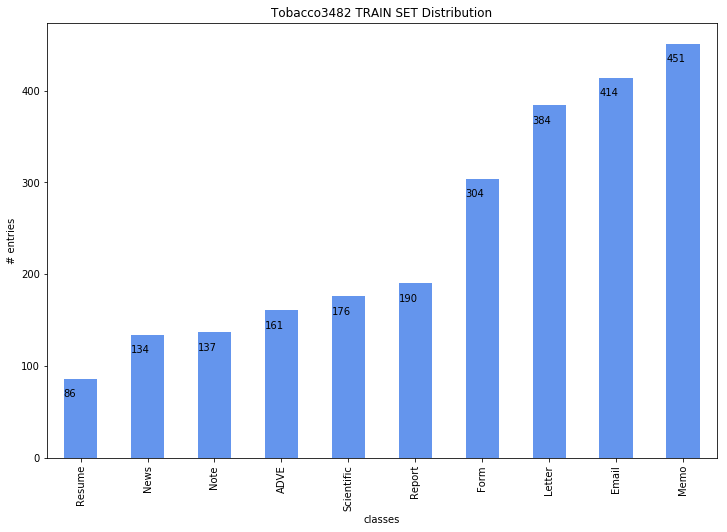

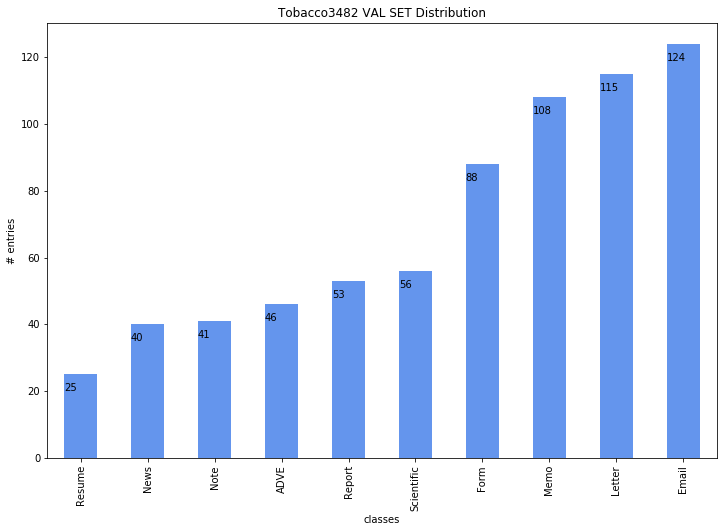

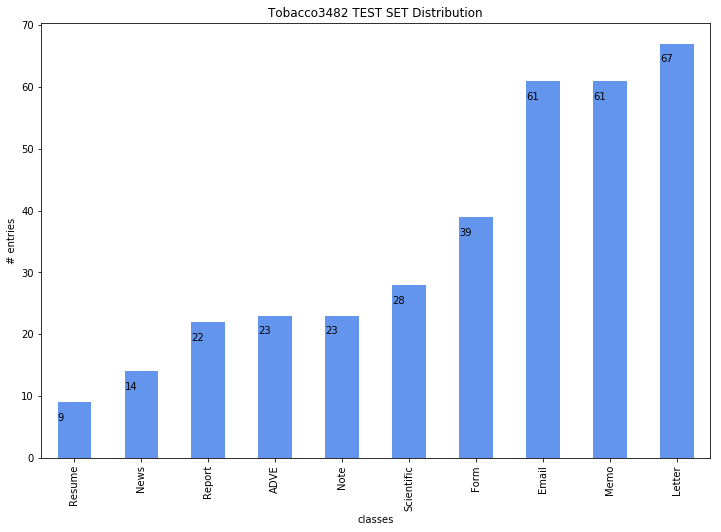

In [7]:
#################################################
# TRAIN SET
instances = [0] * len(classes)
for index, val in enumerate(classes) :
    for e in train_set :
        if(val == getClass(e)) :
            instances[index] += 1

            
df = pd.DataFrame({'classes':classes, 'entries':instances})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('Tobacco3482 TRAIN SET Distribution')
ax.set_ylabel("# entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-20))

#################################################
# VAL SET
instances = [0] * len(classes)
for index, val in enumerate(classes) :
    for e in val_set :
        if(val == getClass(e)) :
            instances[index] += 1

            
df = pd.DataFrame({'classes':classes, 'entries':instances})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('Tobacco3482 VAL SET Distribution')
ax.set_ylabel("# entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-5))
    
#################################################
# TEST SET
instances = [0] * len(classes)
for index, val in enumerate(classes) :
    for e in test_set :
        if(val == getClass(e)) :
            instances[index] += 1

            
df = pd.DataFrame({'classes':classes, 'entries':instances})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('Tobacco3482 TEST SET Distribution')
ax.set_ylabel("# entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-3))

# Preprocess data (resize and transform to Numpy array)

In [8]:
def process_images(img_set) : 
    processed_img = []

    for i in range(len(img_set)) :
        processed_img.append(cv2.resize(cv2.imread(img_set[i], cv2.IMREAD_COLOR), (img_size, img_size)))
    
    return processed_img
    
x_train = process_images(train_set)
x_test = process_images(test_set)
x_val = process_images(val_set)

train shape :  (2437, 299, 299, 3)
(2437, 10)
test shape :  (347, 299, 299, 3)
(347, 10)
valdiation shape :  (696, 299, 299, 3)
(696, 10)
ADVE
[1 0 0 0 0 0 0 0 0 0]
['ADVE' 'Email' 'Form' 'Letter' 'Memo' 'News' 'Note' 'Report' 'Resume'
 'Scientific']


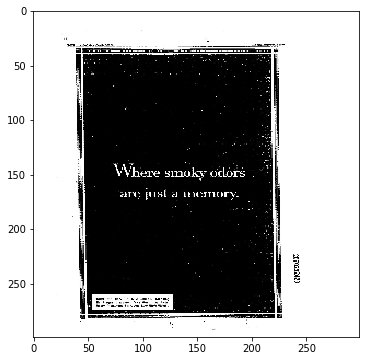

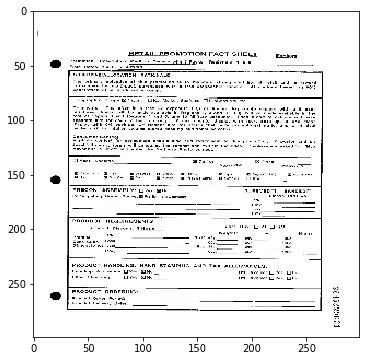

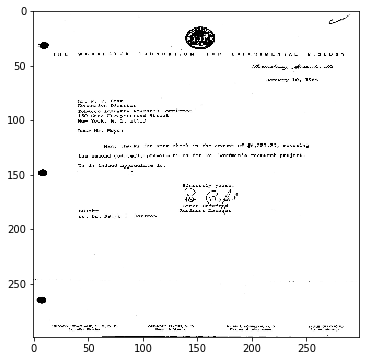

In [9]:
lb = LabelBinarizer()
lb.fit(list(classes))

x_train = np.array(x_train)
y_train =lb.transform(np.array(train_label))

x_test = np.array(x_test)
y_test = lb.transform(np.array(test_label))

x_val = np.array(x_val)
y_val = lb.transform(np.array(val_label))

print("train shape : ", x_train.shape)
print(y_train.shape)
print("test shape : ", x_test.shape)
print(y_test.shape)
print("valdiation shape : ", x_val.shape)
print(y_val.shape)


for i in range(3) :
    plt.figure(figsize=(6,6))
    imgplot = plt.imshow(x_train[i])

print(train_label[0])
print(y_train[0])
print(lb.classes_)

# Creating model (pretrained CNN)

In [10]:
base_model = InceptionV3(weights = "imagenet", include_top=False, input_shape = (img_size, img_size, channels))

#for layer in base_model.layers:
#    layer.trainable = False
    
base_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
87916544/87910968 [==============================] - 3s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0] 

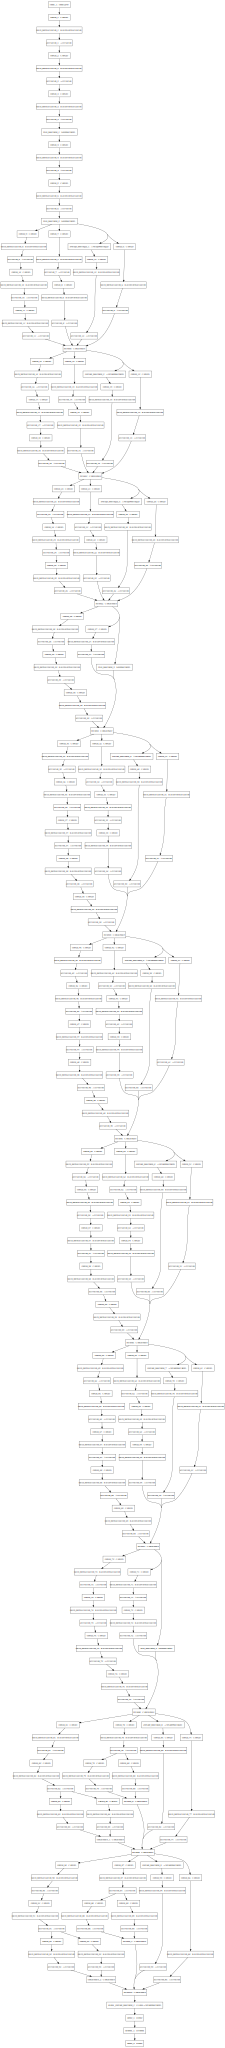

In [11]:
#model = models.Sequential()

#model.add(base_model)
#model.add(layers.Flatten())
#model.add(layers.Dense(128, activation='relu',  name='dense'))
#model.add(layers.Dropout(0.5))
#model.add(layers.Dense(len(classes), activation='softmax',  name='predictions'))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x) 
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

print('Number of trainable weights : ', len(model.trainable_weights))

plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [12]:
model.compile(optimizer=optimizers.Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

train_model = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 2437 samples, validate on 696 samples
Epoch 1/100
2437/2437 [==============================] - 47s 19ms/step - loss: 2.0964 - acc: 0.2425 - val_loss: 1.7736 - val_acc: 0.4152
Epoch 2/100
2437/2437 [==============================] - 27s 11ms/step - loss: 1.7041 - acc: 0.4296 - val_loss: 1.5097 - val_acc: 0.5374
Epoch 3/100
2437/2437 [==============================] - 27s 11ms/step - loss: 1.4307 - acc: 0.5556 - val_loss: 1.2905 - val_acc: 0.6121
Epoch 4/100
2437/2437 [==============================] - 27s 11ms/step - loss: 1.2147 - acc: 0.6307 - val_loss: 1.1199 - val_acc: 0.6609
Epoch 5/100
2437/2437 [==============================] - 27s 11ms/step - loss: 1.0160 - acc: 0.6873 - val_loss: 0.9939 - val_acc: 0.7112
Epoch 6/100
2437/2437 [==============================] - 27s 11ms/step - loss: 0.8777 - acc: 0.7341 - val_loss: 0.9049 - val_acc: 0.7385
Epoch 7/100
2437/2437 [==============================] - 27s 11ms/step - loss: 0.74

# Plot accuracy and loss

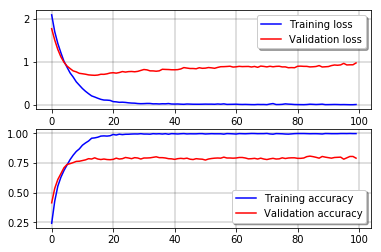

In [13]:
fig, ax = plt.subplots(2,1)
ax[0].plot(train_model.history['loss'], color='b', label="Training loss")
ax[0].plot(train_model.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
ax[0].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(train_model.history['acc'], color='b', label="Training accuracy")
ax[1].plot(train_model.history['val_acc'], color='r',label="Validation accuracy")
ax[1].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[1].legend(loc='best', shadow=True)

# Test prediction accuracy

In [14]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

347/347 [==============================] - 2s 5ms/step
Test loss: 1.0315976022643383
Test accuracy: 0.7953890483042693
